# Coherent One-Way QKD protocol Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import math
from ThOPqkdsim.simCOW import *

<div style="text-align: center;">
    <img src="Figures/COW/COW-QKD-diagram.png" width="800">
</div>

<a name="introduction"></a>
## 1. **Introduction: Quantum Key Distribution and the COW Protocol**

Quantum Key Distribution (QKD) is a method for distributing secret cryptographic keys between two legitimate parties using properties of quantum physics. The **Coherent One-Way (COW) protocol** is a practical QKD scheme designed for high-speed and robust transmission over optical fibers.

- **Key Idea:** The information is encoded in the presence or absence of weak coherent pulses, and a monitoring line is used to detect eavesdropping by verifying coherence between pulses.
- **Advantages:** Simplicity, high key rates, and compatibility with standard telecom components.

<div style="text-align: center;">
    <img src="Figures/COW/QKD_sim-COWqkd-steps.png" width="600">
</div>

<a name="sim-overview"></a>
## 2. **Simulator Architecture Overview**

The simulator is modular, reflecting real-world QKD system components:

- **PhotonSource:** Models the quantum light source, emitting weak coherent pulses with a Poisson-distributed photon number.
- **Channel:** Simulates the optical fiber, including attenuation and distance-dependent losses.
- **Detector:** Models measurement devices with finite efficiency and noise (dark counts).
- **COWProtocol:** Integrates the above components and implements the COW QKD logic, enabling calculation of Quantum Bit Error Rate (QBER) and Secret Key Rate (SKR).

---

<a name="math-background"></a>
## 3. **Mathematical Background**

**Photon emission:**  
Each pulse from a coherent source has a photon number $n$ distributed according to the Poisson law:
$$
P(n; \mu) = \frac{\mu^n}{n!} e^{-\mu}
$$
where $\mu$ is the mean photon number per pulse.

**Channel transmission:**  
Losses are modeled as:
$$
\eta_{\text{channel}} = \eta_{0} \cdot 10^{-\alpha \cdot d / 10}
$$
where $\eta_{0}$ is base efficiency, $\alpha$ is attenuation in dB/km, $d$ is distance in km.

**Detector noise:**  
The probability of a dark count in a window $\Delta t$ is:
$$
p_\text{dark} = 1 - e^{-R_\text{dark} \cdot \Delta t}
$$
where $R_\text{dark}$ is the dark count rate.

**QBER (Quantum Bit Error Rate):**  
QBER arises from both dark counts and phase errors:
$$
Q_\text{bit} = \frac{p_\text{dark}}{P_\text{det} + p_\text{dark}} \\
Q_\text{phase} = \frac{1 - V_\text{eff} e^{-\mu/2}}{2}
$$
where $V_\text{eff}$ is visibility (may degrade with distance).
Total QBER:
$$
Q_\text{total} = 0.5 \times (Q_\text{bit} + Q_\text{phase})
$$

**Secret Key Rate (SKR):**
- **Raw key rate**: $R_\text{raw} = f_\text{rep} \cdot P_\text{det} \cdot r_\text{data} \cdot (1 - p_\text{decoy})$
- **Binary entropy**: $h(Q) = -Q \log_2(Q) - (1-Q)\log_2(1-Q)$
- **Final SKR**:
$$
\text{SKR} = R_\text{raw} \cdot (1 - \lambda) \cdot [1 - f_\text{ec} \cdot h(Q)] \cdot e^{-2\mu}
$$
where $\lambda$ is a security parameter, $f_\text{ec}$ is error correction overhead, $e^{-2\mu}$ penalizes multi-photon pulses.

---

<a name="class-walkthrough"></a>
## 4. **Class-by-Class Code Walkthrough**

---

<a name="photonsource"></a>
### **PhotonSource**

**Purpose:** Models the emission of weak coherent pulses.

- **mu**: Mean photon number per pulse.
- **poisson_distribution()**: Returns $P(n;\mu)$ for $n=0$ to $n_{\max}$.

**Explanation:**  
This class simulates the quantum light source. The photon number in each pulse follows the Poisson distribution described above.

---

In [2]:
class PhotonSource:
    """
    Simulates a coherent light source for COW protocol with controllable mean photon number.
    """
    def __init__(self, mu):
        """
        Initialize the photon source with mean photon number mu.
        
        Args:
            mu (float): Mean photon number per pulse
        """
        self.mu = mu
    
    def poisson_distribution(self, n_max=20):
        """
        Calculate the photon number distribution P(n) up to n_max using Poisson distribution.
        
        Returns:
            np.array: Probability distribution of photon numbers
        """
        n_values = np.arange(n_max + 1)
        probs = poisson.pmf(n_values, self.mu)
        return probs


## Channel Module

### Overview

The `Channel` class models the quantum channel connecting Alice and Bob in a QKD system. It supports both fiber optic and free-space optical (FSO) transmission modes, with realistic physical models for each.

### Class Parameters

#### General Parameters
- `base_efficiency`: Base channel transmission efficiency (at zero distance)
- `distance`: Channel length in kilometers
- `attenuation`: Fiber attenuation coefficient in dB/km (default: 0.2 dB/km)
- `mode`: Channel type - "fiber" or "fso"

#### FSO-Specific Parameters
- `transmitter_efficiency`: Efficiency of transmitter optics (default: 0.9)
- `receiver_efficiency`: Efficiency of receiver optics (default: 0.9)
- `transmitter_diameter`: Diameter of transmitter aperture in meters (default: 0.1m)
- `receiver_diameter`: Diameter of receiver aperture in meters (default: 0.3m)
- `beam_divergence`: Beam divergence angle in radians (default: 1 mrad)
- `wavelength`: Photon wavelength in meters (default: 850nm)
- `pointing_error`: Pointing error in radians (default: 1μrad)

#### Optical Misalignment Parameters
- `misalignment_base`: Base misalignment error (default: 1.5%)
- `misalignment_factor`: Increase in misalignment per km (default: 0.0002)

### Mathematical Models

#### Fiber Channel Efficiency

For fiber optic channels, the efficiency follows the standard exponential attenuation model:

$$\eta_{fiber} = \eta_{base} \cdot 10^{-\frac{\alpha \cdot L}{10}}$$

Where:
- $\eta_{base}$ is the base efficiency
- $\alpha$ is the attenuation coefficient in dB/km
- $L$ is the distance in kilometers

#### FSO Channel Efficiency

For FSO channels, the efficiency is modeled as:

$$\eta_{FSO} = \eta_{base} \cdot G_{geo} \cdot \eta_{tx} \cdot \eta_{rx} \cdot F_{turb} \cdot F_{pointing}$$

Where:
- $\eta_{base}$ is the base efficiency
- $G_{geo}$ is the geometrical loss factor
- $\eta_{tx}$ is the transmitter optical efficiency
- $\eta_{rx}$ is the receiver optical efficiency
- $F_{turb}$ is the turbulence-induced loss factor
- $F_{pointing}$ is the pointing error loss factor

##### Geometrical Loss Factor

$$G_{geo} = (\frac{D_{rx}}{D_{beam}})^2t$$

Where:
- $D_{rx}$ is the receiver aperture diameter
- $D_{beam} = D_{tx} + L \cdot \theta_{div}$ is the beam diameter at the receiver
- $D_{tx}$ is the transmitter aperture diameter
- $\theta_{div}$ is the beam divergence angle

##### Turbulence-Induced Loss

$$F_{turb} = e^{-0.05L}$$

##### Pointing Error Loss

$$F_{pointing} = \exp\left(-\frac{2\sigma_p^2}{w_L^2}\right)$$

Where:
- $\sigma_p^2 = (\theta_{err} \cdot L)^2$ is the pointing error variance
- $\theta_{err}$ is the pointing error angle
- $w_L^2 = (\theta_{div} \cdot L / 2)^2$ is the beam spot size at distance $L$

In [ ]:
class Channel:
    """
    Represents the quantum channel between Alice and Bob.
    Includes both fiber and FSO (Free Space Optical) channel modeling options.
    """
    def __init__(self, base_efficiency, distance=0, attenuation=0.2, mode="fiber"):
        """
        Initialize the channel with distance-dependent efficiency.
        
        Args:
            base_efficiency (float): Base channel transmission efficiency without distance (0-1)
            distance (float): Channel distance in kilometers
            attenuation (float): Fiber attenuation coefficient in dB/km
            mode (str): Channel mode - "fiber" or "fso"
        """
        self.base_efficiency = base_efficiency
        self.distance = distance
        self.attenuation = attenuation
        
        # FSO specific parameters with default values
        self.transmitter_efficiency = 0.9  # Efficiency of transmitter optics
        self.receiver_efficiency = 0.9     # Efficiency of receiver optics
        self.transmitter_diameter = 0.1    # Diameter of transmitter aperture in meters
        self.receiver_diameter = 0.3       # Diameter of receiver aperture in meters
        self.beam_divergence = 0.001       # Beam divergence angle in radians (1 mrad)
        self.wavelength = 850e-9           # Wavelength in meters (850 nm)
        self.pointing_error = 1e-6         # Pointing error in radians
        
        # Optical misalignment that increases with distance
        self.misalignment_base = 0.015     # 1.5% base misalignment error
        self.misalignment_factor = 0.0002  # Increase per km
        
        # Set mode and calculate efficiency
        self.mode = mode
        self.efficiency = self.calculate_efficiency()
    
    def calculate_efficiency(self):
        """
        Calculate the actual channel efficiency based on distance and mode.
        
        Returns:
            float: Actual channel efficiency after distance attenuation
        """
        if self.mode == "fiber":
            return self._calculate_fiber_efficiency()
        elif self.mode == "fso":
            return self._calculate_fso_efficiency()
        else:
            raise ValueError(f"Unknown channel mode: {self.mode}")
    
    def _calculate_fiber_efficiency(self):
        """
        Calculate efficiency for fiber optic channel.
        
        Returns:
            float: Channel efficiency for fiber
        """
        # Calculate attenuation in dB
        attenuation_db = self.distance * self.attenuation
        
        # Convert to transmission efficiency: 10^(-attenuation_db/10)
        distance_factor = 10**(-attenuation_db/10)
        
        # Total efficiency is base efficiency times distance factor
        return self.base_efficiency * distance_factor
    
    def _calculate_fso_efficiency(self):
        """
        Calculate efficiency for FSO channel based on provided model.
        
        Returns:
            float: Channel efficiency for FSO
        """
        # For zero distance, return direct efficiency without atmospheric effects
        if self.distance <= 1e-6:  # Effectively zero
            return self.base_efficiency * self.transmitter_efficiency * self.receiver_efficiency
    
        # Calculate geometrical loss factor
        beam_diameter_at_receiver = self.transmitter_diameter + (self.distance * 1000 * self.beam_divergence)
        geo_factor = min(1.0, (self.receiver_diameter / beam_diameter_at_receiver)**2)
        
        # Calculate simplified turbulence-induced scintillation loss
        # Using a simplified model based on distance
        turb_factor = np.exp(-0.05 * self.distance)  # Simplified exponential decay with distance
        
        # Calculate simplified beam wandering effect
        # Increases with distance
        pointing_variance = (self.pointing_error * self.distance * 1000)**2
        beam_spot_size = (self.beam_divergence * self.distance * 1000 / 2)**2
        bw_factor = np.exp(-2 * pointing_variance / beam_spot_size)
        
        # Calculate overall transmission efficiency
        total_efficiency = (self.base_efficiency * geo_factor * self.transmitter_efficiency * 
                            self.receiver_efficiency * turb_factor * bw_factor)
        
        return min(1.0, max(0.0, total_efficiency))  # Ensure efficiency is between 0 and 1
    
    def update_distance(self, distance):
        """
        Update the channel distance and recalculate efficiency.
        
        Args:
            distance (float): New channel distance in kilometers
        """
        self.distance = distance
        self.efficiency = self.calculate_efficiency()
    
    def update_mode(self, mode):
        """
        Update the channel mode and recalculate efficiency.
        Default FSO parameters are automatically used when switching to FSO mode.
        
        Args:
            mode (str): New channel mode ("fiber" or "fso")
        """
        if mode not in ["fiber", "fso"]:
            raise ValueError(f"Unsupported channel mode: {mode}. Use 'fiber' or 'fso'.")
            
        self.mode = mode
        self.efficiency = self.calculate_efficiency()
    
    def set_fso_parameters(self, transmitter_diameter=None, receiver_diameter=None, 
                          beam_divergence=None, wavelength=None, pointing_error=None,
                          transmitter_efficiency=None, receiver_efficiency=None):
        """
        Update FSO-specific parameters. Only updates the parameters that are provided.
        
        Args:
            transmitter_diameter (float, optional): Diameter of transmitter aperture in meters
            receiver_diameter (float, optional): Diameter of receiver aperture in meters
            beam_divergence (float, optional): Beam divergence angle in radians
            wavelength (float, optional): Wavelength in meters
            pointing_error (float, optional): Pointing error in radians
            transmitter_efficiency (float, optional): Efficiency of transmitter optics
            receiver_efficiency (float, optional): Efficiency of receiver optics
        """
        if transmitter_diameter is not None:
            self.transmitter_diameter = transmitter_diameter
        if receiver_diameter is not None:
            self.receiver_diameter = receiver_diameter
        if beam_divergence is not None:
            self.beam_divergence = beam_divergence
        if wavelength is not None:
            self.wavelength = wavelength
        if pointing_error is not None:
            self.pointing_error = pointing_error
        if transmitter_efficiency is not None:
            self.transmitter_efficiency = transmitter_efficiency
        if receiver_efficiency is not None:
            self.receiver_efficiency = receiver_efficiency
            
        # Recalculate efficiency if in FSO mode
        if self.mode == "fso":
            self.efficiency = self.calculate_efficiency()
    
    def transmission_probability(self, sent_photons, received_photons):
        """
        Calculate probability of receiving photons given sent photons.
        
        Args:
            sent_photons (int): Number of photons sent
            received_photons (int): Number of photons received
            
        Returns:
            float: Probability of receiving the specified number of photons
        """
        if received_photons > sent_photons:
            return 0.0
        
        return binom.pmf(received_photons, sent_photons, self.efficiency)
    
    def transmit_pulse(self, is_non_empty):
        """
        Simulates the transmission of a pulse through the channel.
        
        Args:
            is_non_empty (bool): True if the pulse contains photons, False for empty pulse
            
        Returns:
            bool: True if the pulse is detected, False otherwise
        """
        if not is_non_empty:
            return False
        
        # Probability of detection is based on the channel efficiency
        return np.random.random() < self.efficiency

<a name="detector"></a>
### **Detector**

**Purpose:** Models a single-photon detector including detection efficiency and dark counts.

- **efficiency**: Probability that an incoming photon is detected.
- **dark_count_rate**: Random "false" counts per second.
- **time_window**: Time window for pulse detection.
- **p_dark**: Probability of a dark count in any given window.

**Explanation:**  
The detector randomly "clicks" either due to a real photon (with probability = efficiency) or a dark count (with probability $p_\text{dark}$).

---

In [2]:
class Detector:
    """
    Represents a single-photon detector with noise characteristics.
    """
    def __init__(self, efficiency=0.2, dark_count_rate=500, time_window=1e-9):
        """
        Initialize detector with its characteristics.
        
        Args:
            efficiency (float): Detector efficiency (0-1)
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
        """
        self.efficiency = efficiency
        self.dark_count_rate = dark_count_rate
        self.time_window = time_window
        self.p_dark = 1 - np.exp(-dark_count_rate * time_window)
    
    def detect(self, received_pulse):
        """
        Simulates the detection process with detector efficiency and dark counts.
        
        Args:
            received_pulse (bool): True if pulse is received at the detector, False otherwise
            
        Returns:
            bool: True if detector clicks, False otherwise
        """
        # Check for dark count
        dark_count = np.random.random() < self.p_dark
        
        # Check for detection of received photon
        photon_detection = received_pulse and (np.random.random() < self.efficiency)
        
        # Detector clicks if either condition is met
        return dark_count or photon_detection


## COW Protocol Simulator

### Overview

The `COWProtocol` class implements a simulation of the Coherent One-Way (COW) Quantum Key Distribution protocol. This protocol uses time-bin encoding and an asymmetric Mach-Zehnder interferometer for security monitoring.

### Class Parameters

#### Protocol Parameters
- `mu`: Mean photon number per non-empty pulse (default: 0.5)
- `decoy_probability`: Probability of sending a decoy sequence (default: 0.1 or 10%)
- `data_line_ratio`: Fraction of photons directed to the data line vs. monitoring line (default: 0.9 or 90%)
- `repetition_rate`: Pulse repetition rate in Hz (default: 500 MHz)

#### Hardware Components
- `source`: Photon source for generating quantum states
- `channel`: Quantum channel between Alice and Bob (fiber or FSO)
- `data_detector`: Detector for the direct data line
- `monitor_detector_1`: First monitoring interferometer detector
- `monitor_detector_2`: Second monitoring interferometer detector

#### Channel Parameters
- `distance`: Distance between Alice and Bob in kilometers
- `channel_base_efficiency`: Base efficiency of the quantum channel
- `attenuation`: Fiber attenuation coefficient in dB/km
- `channel_mode`: Type of channel - "fiber" or "fso"

#### Detector Parameters
- `detector_efficiency`: Efficiency of Bob's detectors
- `dark_count_rate`: Dark count rate in counts per second
- `time_window`: Detection time window in seconds

#### Performance Parameters
- `interference_visibility`: Quality of the interferometer (default: 0.98)
- `error_correction_efficiency`: Practical error correction overhead (default: 1.2)
- `security_parameter`: Parameter for privacy amplification (default: 0.5)

In [ ]:
class COWProtocolbb84:
    """
    Simulates the Coherent One-Way QKD protocol.
    """
    def __init__(self, mu=0.5, distance=0, 
                 detector_efficiency=0.2, 
                 dark_count_rate=500,
                 time_window=1e-9,
                 channel_base_efficiency=0.8,
                 attenuation=0.2,
                 channel_mode="fiber",  # New parameter for channel mode
                 data_line_ratio=0.9,  # 90% for data line, 10% for monitoring line
                 decoy_probability=0.1,  # Probability of sending a decoy sequence
                 repetition_rate=500e6):  # 500 MHz pulse repetition rate
        """
        Initialize the COW protocol simulator.
        
        Args:
            mu (float): Mean photon number
            distance (float): Distance between Alice and Bob in kilometers
            detector_efficiency (float): Bob's detector efficiency
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
            channel_base_efficiency (float): Base efficiency of channel
            attenuation (float): Fiber attenuation coefficient in dB/km
            channel_mode (str): Channel mode - "fiber" or "fso"
            data_line_ratio (float): Fraction of photons sent to data line (0-1)
            decoy_probability (float): Probability of sending a decoy sequence
            repetition_rate (float): Pulse repetition rate in Hz
        """
        self.source = PhotonSource(mu)
        self.mu = mu
        self.channel = Channel(channel_base_efficiency, distance, attenuation, channel_mode)
        self.data_detector = Detector(detector_efficiency, dark_count_rate, time_window)
        self.monitor_detector_1 = Detector(detector_efficiency, dark_count_rate, time_window)
        self.monitor_detector_2 = Detector(detector_efficiency, dark_count_rate, time_window)
        self.distance = distance
        self.data_line_ratio = data_line_ratio
        self.decoy_probability = decoy_probability
        self.repetition_rate = repetition_rate
        self.channel_mode = channel_mode
        
        # Pre-calculate some frequently used values
        self.interference_visibility = 0.98  # Interferometer visibility
        
        # Parameters for error correction and privacy amplification
        self.error_correction_efficiency = 1.2  # Practical error correction overhead
        self.security_parameter = 0.5  # Monitoring line parameter

#### **Core Methods:**

##### **Distance, Channel, Source Updates**
*Update simulation parameters on-the-fly.*

In [ ]:
def update_distance(self, distance):
        """
        Update the distance and recalculate channel efficiency.
        
        Args:
            distance (float): New distance in kilometers
        """
        self.distance = distance
        self.channel.update_distance(distance)

def update_mu(self, mu):
        """
        Update the mean photon number.
        
        Args:
            mu (float): New mean photon number
        """
        self.mu = mu
        self.source = PhotonSource(mu)

def update_channel_mode(self, mode):
        """
        Update the channel mode between fiber and FSO.
        
        Args:
            mode (str): New channel mode ("fiber" or "fso")
        """
        if mode not in ["fiber", "fso"]:
            raise ValueError(f"Unsupported channel mode: {mode}. Use 'fiber' or 'fso'.")
        
        self.channel_mode = mode
        self.channel.update_mode(mode)
    
    def set_fso_parameters(self, **kwargs):
        """
        Set parameters specific to FSO channel.
        
        Args:
            **kwargs: Key-value pairs of FSO parameters to update
                Possible keys: transmitter_diameter, receiver_diameter, beam_divergence,
                wavelength, pointing_error, transmitter_efficiency, receiver_efficiency
        """
        self.channel.set_fso_parameters(**kwargs)
    

##### **Phase QBER Calculation**
*Models how phase errors (imperfect interference) increase with distance and mean photon number.*


In [5]:
def _calculate_phase_qber(self):
        """
        Calculate the QBER component due to phase errors in COW protocol.
        This increases with distance due to imperfect visibility.
        
        Returns:
            float: Phase QBER component
        """
        # Apply distance-dependent visibility degradation
        distance_factor = 1 + 0.001 * self.distance  # Empirical visibility degradation
        effective_visibility = self.interference_visibility / distance_factor
        
        # Phase QBER based on visibility and mean photon number
        qber_phase = (1 - effective_visibility * np.exp(-self.mu/2)) / 2
        return qber_phase

##### **QBER Calculation**
*Combines bit and phase error sources. Returns QBER as a percentage.*

In [6]:
def calculate_qber(self):
        """
        Calculate the quantum bit error rate (QBER) for COW protocol.
        
        Returns:
            float: QBER as a percentage
        """
        # Calculate detection probabilities
        transmittance = self.channel.efficiency
        detection_prob = 1 - np.exp(-self.mu * transmittance * self.data_detector.efficiency)
        
        # Calculate bit error component (from dark counts)
        dark_count_prob = self.data_detector.p_dark
        qber_bit = dark_count_prob / (detection_prob + dark_count_prob) if (detection_prob + dark_count_prob) > 0 else 0.5
        
        # Calculate phase error component (from visibility and coherence)
        qber_phase = self._calculate_phase_qber()
        
        # Total QBER is a weighted combination of bit errors and phase errors
        qber_total = 0.5 * (qber_bit + qber_phase)
        
        # Convert to percentage
        return qber_total * 100
    

##### **Binary Entropy**
*Used for privacy amplification calculations.*

In [7]:
def _h_binary(self, p):
        """
        Binary entropy function H(p) = -p*log2(p) - (1-p)*log2(1-p).
        
        Args:
            p (float): Probability (0 <= p <= 1)
            
        Returns:
            float: Binary entropy value
        """
        if p == 0 or p == 1:
            return 0
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

##### **Secret Key Rate (SKR) Calculation**
- **raw_key_rate:** Product of repetition rate, detection probability, data line fraction, and non-decoy probability.
- **qber:** From previous calculation.
- **multi_photon_factor:** Penalizes multi-photon pulses, which are less secure.
- **secret_fraction:** Accounts for error correction, privacy amplification, and security parameter.
- **Returns:** Final SKR in bits/sec.

In [8]:
def calculate_skr(self):
        """
        Calculate the Secret Key Rate (SKR) for COW protocol.
        
        Returns:
            float: Secret key rate in bits per second
        """
        # Calculate detection probabilities
        transmittance = self.channel.efficiency
        detection_prob = 1 - np.exp(-self.mu * transmittance * self.data_detector.efficiency)
        
        # Calculate raw key rate
        # For low mu, detection probability is approximately linear with mu
        # For high mu, multi-photon events increase and reduce security
        raw_key_rate = self.repetition_rate * detection_prob * self.data_line_ratio * (1 - self.decoy_probability)
        
        # Calculate QBER (as a fraction, not percentage)
        qber = self.calculate_qber() / 100
        
        # If QBER is too high, no secure key is possible
        if qber >= 0.11:  # Security threshold for COW
            return 0
            
        # Multi-photon penalty factor - reduces security for high mu values
        # This factor creates the bell-shaped curve for SKR vs mu
        multi_photon_factor = np.exp(-2 * self.mu)  # Strongly penalize multi-photon events
        
        # Calculate secret key fraction after privacy amplification and error correction
        secret_fraction = (1 - self.security_parameter) * (1 - self.error_correction_efficiency * self._h_binary(qber))
        secret_fraction = secret_fraction * multi_photon_factor
        
        # Ensure the fraction is non-negative
        secret_fraction = max(0, secret_fraction)
        
        # Calculate final secret key rate
        skr = raw_key_rate * secret_fraction
        
        return skr

# QBER Calculation

<div style="text-align: center;">
    <img src="Figures/COW/QKD_sim-COWqkd-qber.png" width="900">
</div>

# SKR Calculation

<div style="text-align: center;">
    <img src="Figures/COW/QKD_sim-Copy of COWqkd-skr.png" width="550">
</div>

<a name="plotting"></a>
## 5. **Plotting and Results Visualization**

The module provides functions to visualize QBER and SKR as a function of mean photon number $\mu$ and channel distance $d$.

- **plot_qber_vs_mu**: QBER vs. $\mu$ at fixed distance.
- **plot_qber_vs_distance**: QBER vs. distance at fixed $\mu$.
- **plot_skr_vs_mu**: SKR vs. $\mu$ at fixed distance.
- **plot_skr_vs_distance**: SKR vs. distance at fixed $\mu$.

Each plotting function:
  - Instantiates the `COWProtocol` simulator.
  - Sweeps the parameter of interest.
  - Plots results with Matplotlib.

---

In [14]:
def run_cow_qkd_simulation_fiber():
    # Generate basic plots with specific ranges and parameters
    print("Generating QBER vs Mean Photon Number plot...")
    plot_qber_vs_mu(mu_values=np.linspace(0.01, 1.0, 20), distance=50, channel_mode='fiber')
    
    print("Generating QBER vs Distance plot...")
    plot_qber_vs_distance(distance_values=np.linspace(0, 200, 20), mu=0.3, channel_mode='fiber')

    print("Generating SKR vs Mean Photon Number plot...")
    # Using a smaller range for mu to better show the bell curve shape
    plot_skr_vs_mu(mu_values=np.linspace(0.01, 0.8, 20), distance=50, channel_mode='fiber')

    print("Generating SKR vs Distance plot...")
    # Using a more optimal mu value
    plot_skr_vs_distance(distance_values=np.linspace(0, 200, 20), mu=0.3, channel_mode='fiber')

    print("All plots have been generated successfully!")

def run_cow_qkd_simulation_fso():
    # Generate basic plots with specific ranges and parameters
    print("Generating QBER vs Mean Photon Number plot...")
    plot_qber_vs_mu(mu_values=np.linspace(0.01, 1, 50), distance=5, channel_mode='fso')

    print("Generating QBER vs Distance plot...")
    plot_qber_vs_distance(distance_values=np.linspace(0, 50, 50), mu=0.3, channel_mode='fso')

    print("Generating SKR vs Mean Photon Number plot...")
    # Using a smaller range for mu to better show the bell curve shape
    plot_skr_vs_mu(mu_values=np.linspace(0.01, 1, 50), distance=5, channel_mode='fso')

    print("Generating SKR vs Distance plot...")
    # Using a more optimal mu value
    plot_skr_vs_distance(distance_values=np.linspace(0, 25, 50), mu=0.3, channel_mode='fso')

    print("All plots have been generated successfully!")


Generating QBER vs Mean Photon Number plot...


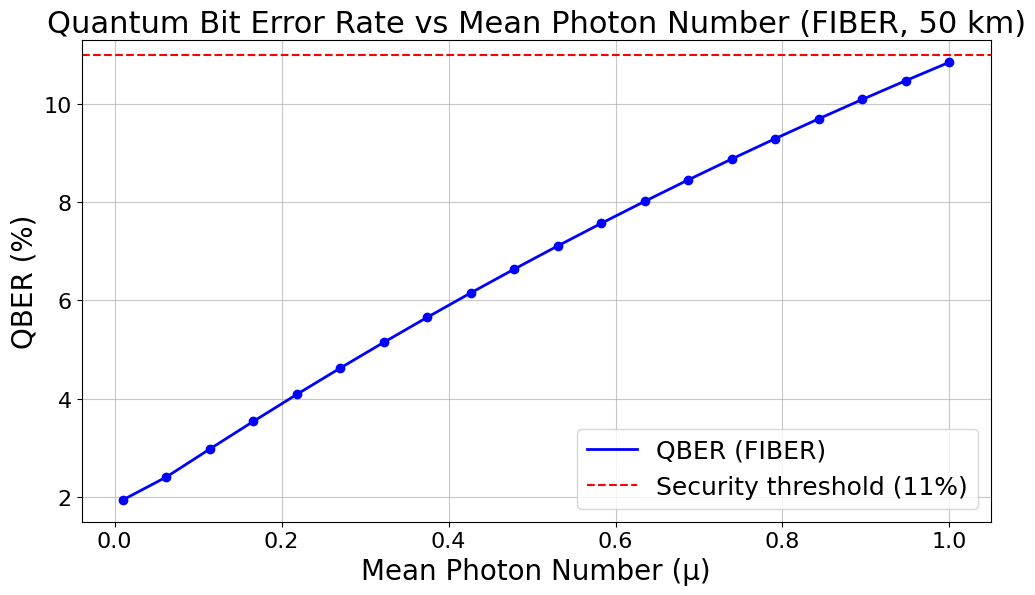

Generating QBER vs Distance plot...


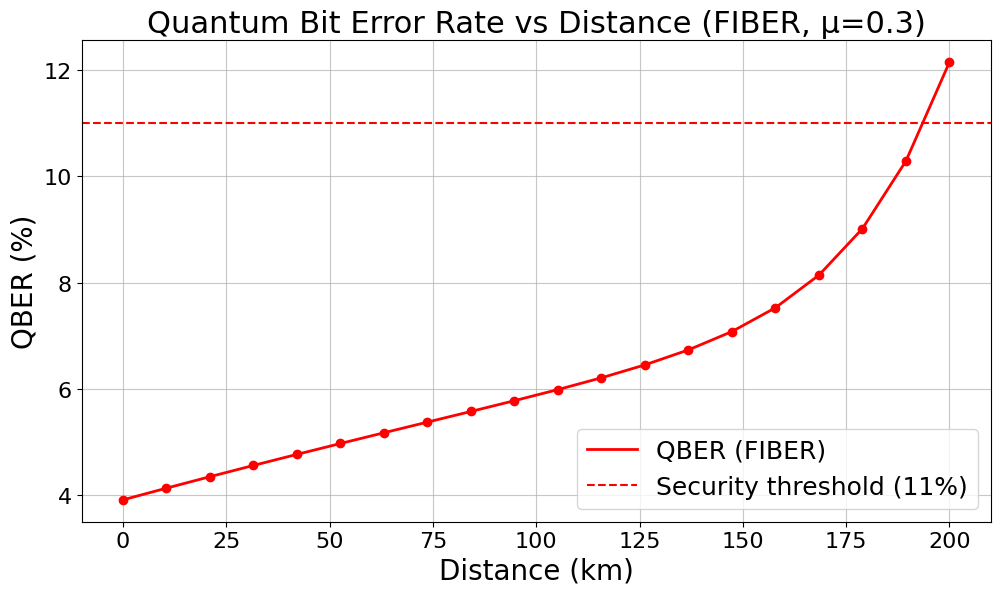

Generating SKR vs Mean Photon Number plot...


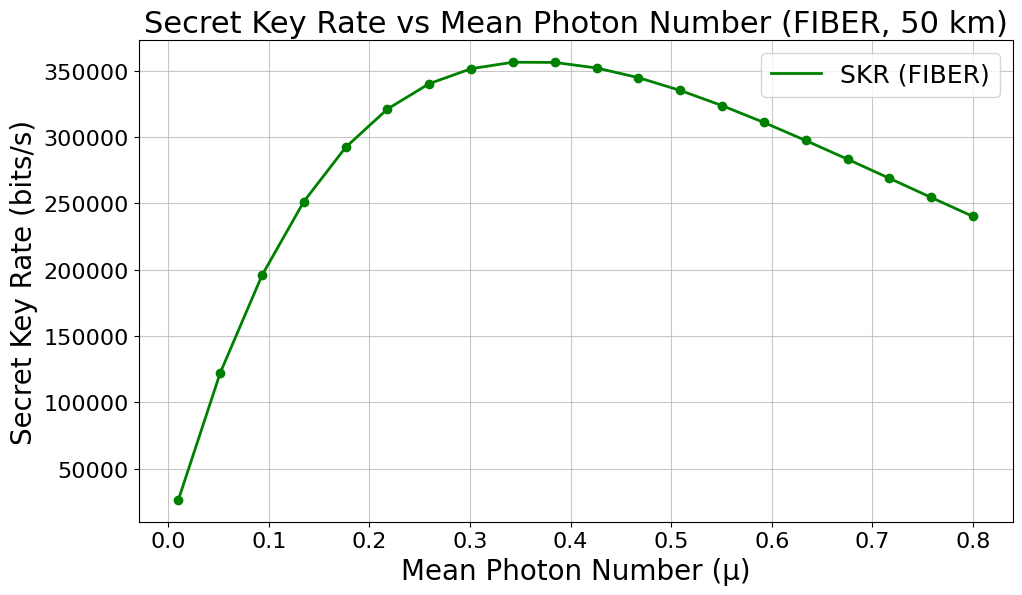

Generating SKR vs Distance plot...


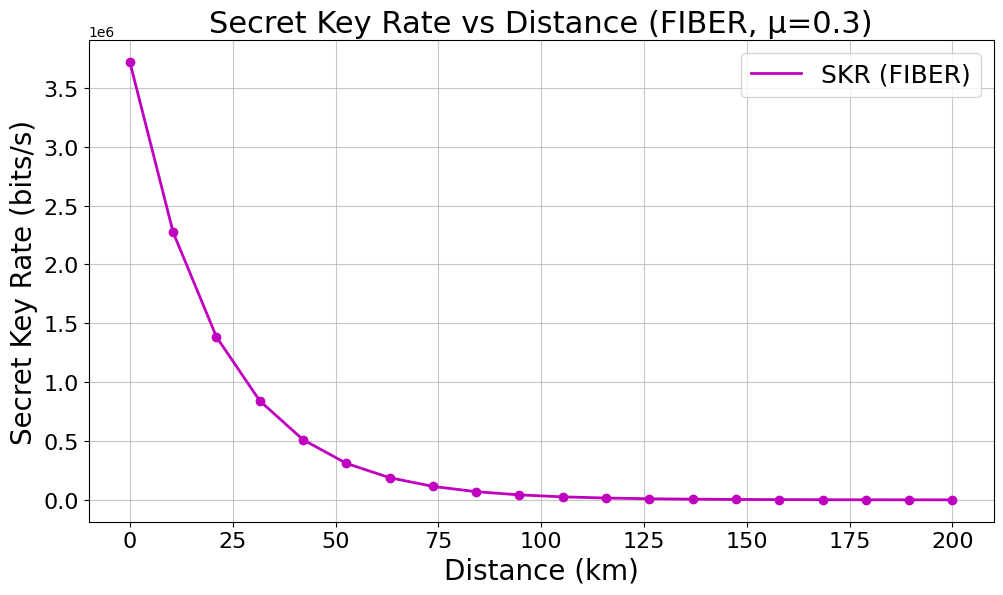

All plots have been generated successfully!


In [15]:
run_cow_qkd_simulation_fiber()

Generating QBER vs Mean Photon Number plot...


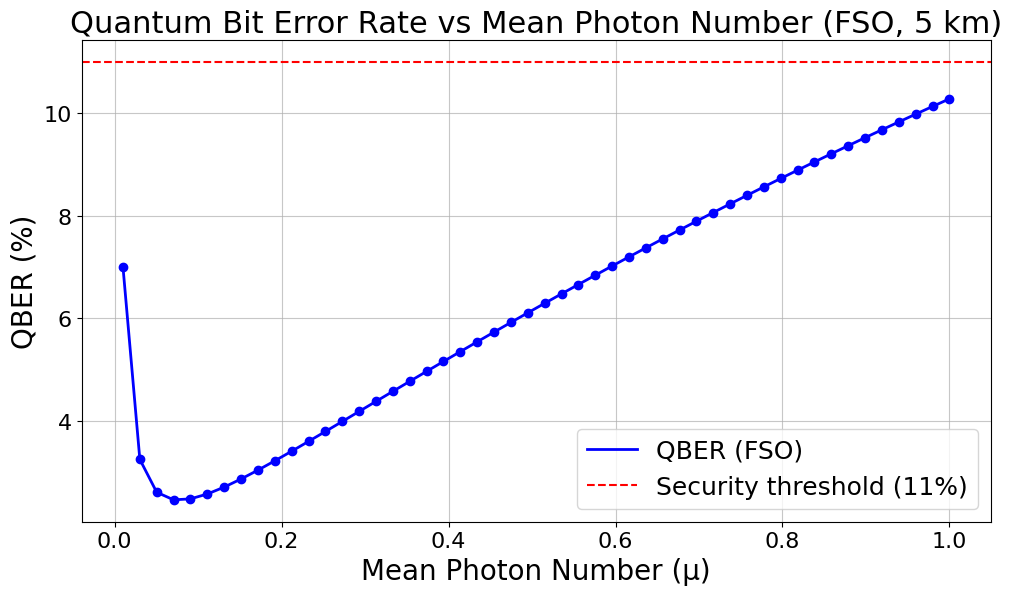

Generating QBER vs Distance plot...


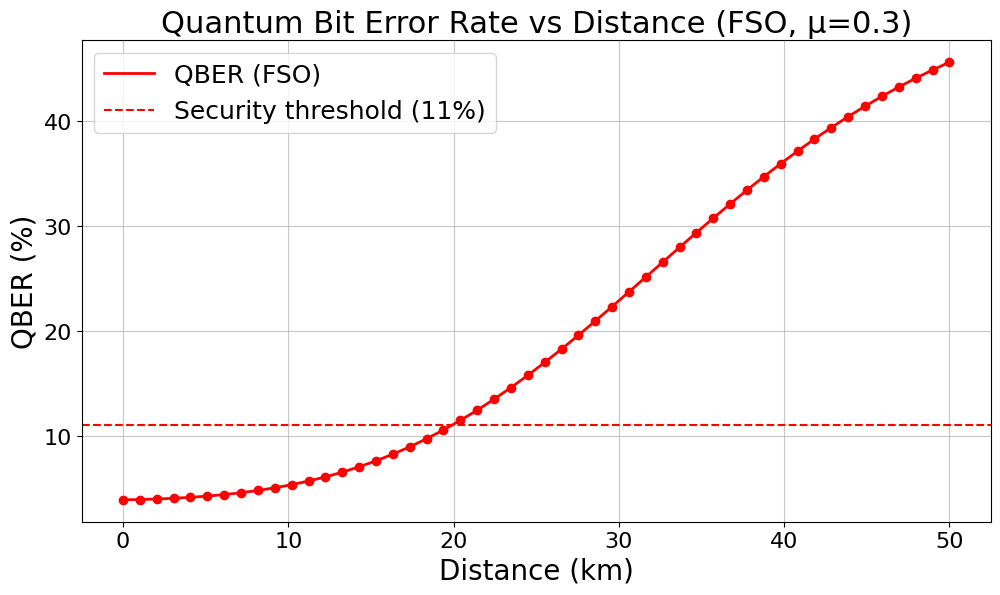

Generating SKR vs Mean Photon Number plot...


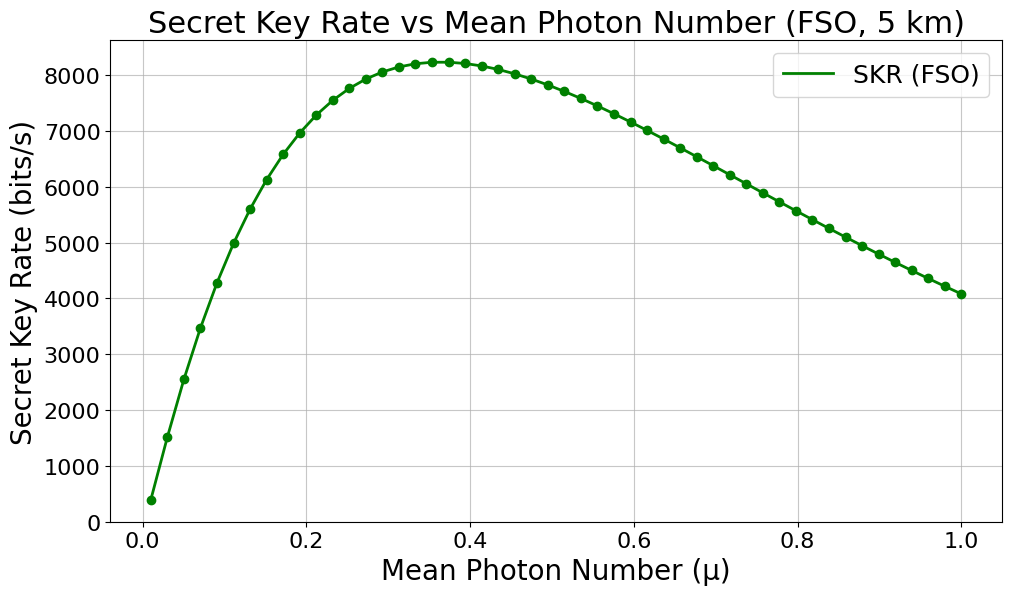

Generating SKR vs Distance plot...


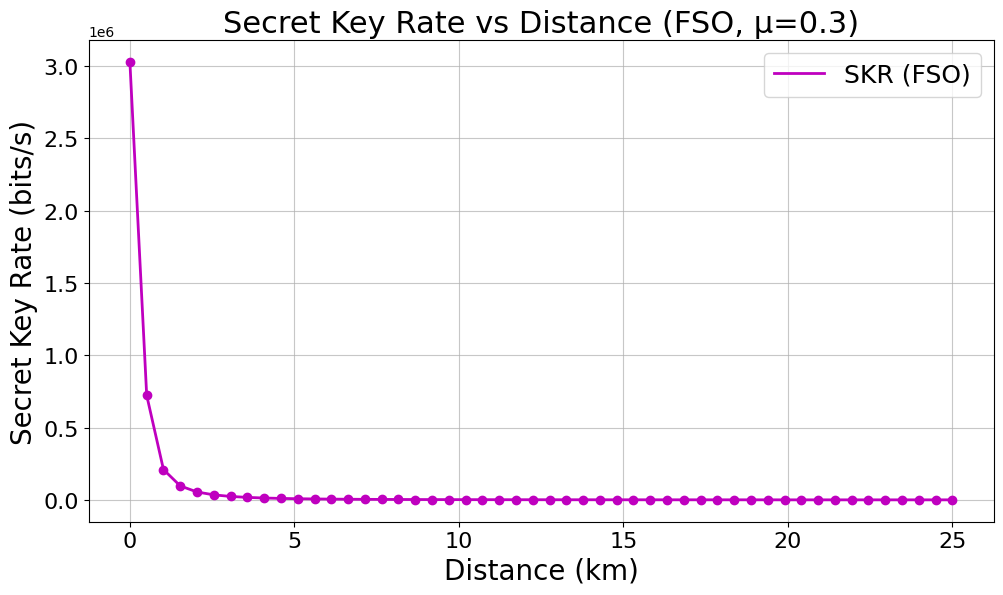

All plots have been generated successfully!


In [16]:
run_cow_qkd_simulation_fso()

## **Conclusion**

This module provided a comprehensive, hands-on exploration of the Coherent One-Way (COW) QKD protocol using a Python-based simulator. We broke down the simulation into modular components—photon source, quantum channel, detectors, and the protocol logic—allowing for an intuitive understanding of each part’s physical and mathematical foundations. 
By actively experimenting with the simulator—adjusting parameters like mean photon number ($\mu$), channel length, and detector properties—you can gain deeper insights into the robustness and limitations of the COW protocol. Such simulations are crucial for bridging the gap between quantum information theory and experimental implementation, making abstract concepts tangible and actionable.

---

## **Future Work**

While the current simulator captures many essential features of the COW QKD protocol, there are several directions for future enhancement:

1. **Eavesdropping Attacks:**  
   - **Implementation:** Incorporate explicit models of common attacks (e.g., intercept-resend, photon-number-splitting, Trojan horse) to evaluate protocol security under realistic adversarial conditions.
   - **Benefit:** Enables users to study protocol resilience and countermeasures.

2. **Finite-Key Analysis:**  
   - **Implementation:** Add statistical analysis for QKD with finite key lengths, rather than assuming infinite statistics.
   - **Benefit:** Improves accuracy for real-world deployments where only a limited number of pulses are exchanged.

3. **Device Imperfections:**  
   - **Implementation:** Simulate additional imperfections such as detector dead time, afterpulsing, timing jitter, and source fluctuations.
   - **Benefit:** Provides a more faithful representation of experimental systems.

4. **Parameter Optimization:**  
   - **Implementation:** Automate the optimization of protocol parameters ($\mu$, repetition rate, etc.) for given channel conditions to maximize SKR.
   - **Benefit:** Guides practical system design for different network scenarios.

5. **Support for Other Protocols:**  
   - **Implementation:** Extend the simulator framework to include other QKD protocols (e.g., BB84, decoy-state, DPS).
   - **Benefit:** Facilitates comparison and hybrid protocol research.

6. **User Interface and Visualization:**  
   - **Implementation:** Develop a graphical user interface (GUI) or web-based dashboard for interactive parameter tuning and results visualization.
   - **Benefit:** Lowers the barrier to entry for students and researchers new to QKD.